Import Library

In [ ]:
!pip install tensorflow-addons

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 591.0/591.0 kB 16.9 MB/s eta 0:00:00


In [ ]:
import os
import tensorflow as tf
import pandas as pd
import matplotlib.pyplot as plt
from tensorflow.keras.regularizers import l2
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Flatten, Activation, Dropout, BatchNormalization, GaussianNoise
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from keras.callbacks import EarlyStopping

Define the dataset paths and parameters

In [ ]:
# Mount Google Drive
from google.colab import drive

drive.mount('/content/drive/')

Mounted at /content/drive/


In [ ]:
base_dir = '/content/drive/MyDrive/Flex Model/merged_dataset'
train_data_dir = os.path.join(base_dir, 'train', 'dataset')
val_data_dir = os.path.join(base_dir, 'valid', 'dataset')
test_data_dir = os.path.join(base_dir, 'test', 'dataset')
annotations_train_file = os.path.join(base_dir, 'train', '_annotations.csv')
annotations_val_file = os.path.join(base_dir, 'valid', '_annotations.csv')
annotations_test_file = os.path.join(base_dir, 'test', '_annotations.csv')

Load and preprocess the data

In [ ]:
batch_size = 512

In [ ]:
annotations_train = pd.read_csv(annotations_train_file)
annotations_val = pd.read_csv(annotations_val_file)
annotations_test = pd.read_csv(annotations_test_file)

annotations_train['class'] = annotations_train['class'].astype(str)
annotations_val['class'] = annotations_val['class'].astype(str)
annotations_test['class'] = annotations_test['class'].astype(str)

# Create image data generators with augmentation for training and validation
# Define custom preprocessing function
# def preprocess_image(image):
#     # Add Gaussian noise
#     noisy_image = GaussianNoise(0.1)(image, training=True)

#     # Adjust saturation
#     saturated_image = tf.image.random_saturation(noisy_image, lower=0.5, upper=1.5)

#     # Adjust brightness
#     brightened_image = tf.image.random_brightness(saturated_image, max_delta=0.2)

#     # Adjust contrast
#     contrasted_image = tf.image.random_contrast(brightened_image, lower=0.7, upper=1.3)

#     # Rescale to [0, 1]
#     preprocessed_image = tf.clip_by_value(contrasted_image, 0.0, 1.0)

#     return preprocessed_image

# Create image data generators with augmentation for training and validation
train_datagen = ImageDataGenerator(
    rescale=1.0/255.0,
    rotation_range=20,
    zoom_range=0.2,
    horizontal_flip=True,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    # preprocessing_function=preprocess_image
)

val_datagen = ImageDataGenerator(rescale=1.0/255.0)

# Load and preprocess the training data
train_generator = train_datagen.flow_from_dataframe(
    dataframe=annotations_train,
    directory=train_data_dir,
    x_col='filename',
    y_col='class',
    target_size=(224, 224),
    batch_size=batch_size,
    class_mode='binary'
)

# Load and preprocess the validation data
val_generator = val_datagen.flow_from_dataframe(
    dataframe=annotations_val,
    directory=val_data_dir,
    x_col='filename',
    y_col='class',
    target_size=(224, 224),
    batch_size=batch_size,
    class_mode='binary',
    shuffle=False
)

/usr/local/lib/python3.10/dist-packages/keras/preprocessing/image.py:1137: UserWarning: Found 2666 invalid image filename(s) in x_col="filename". These filename(s) will be ignored.
  warnings.warn(


Found 256801 validated image filenames belonging to 2 classes.
Found 7944 validated image filenames belonging to 2 classes.


/usr/local/lib/python3.10/dist-packages/keras/preprocessing/image.py:1137: UserWarning: Found 1444 invalid image filename(s) in x_col="filename". These filename(s) will be ignored.
  warnings.warn(


In [ ]:
num_classes = annotations_train['class'].nunique()

Build the model

In [ ]:
# Load the MobileNetV2 model (pretrained on ImageNet)
base_model = MobileNetV2(include_top=False, weights='imagenet', input_shape=(224, 224, 3))

# Add custom layers on top of the base model
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = BatchNormalization()(x)
x = Dropout(0.4)(x)
x = Dense(512, activation='relu', kernel_regularizer=l2(0.01))(x)
x = BatchNormalization()(x)
x = Dropout(0.5)(x)
predictions = Dense(1, activation='sigmoid')(x)

# Create the final model
model = Model(inputs=base_model.input, outputs=predictions)

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])


Train the model

In [ ]:
# Define the early stopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=3)

In [ ]:
# history = model.fit(
#     train_generator,
#     steps_per_epoch=train_generator.n // batch_size,
#     epochs=3,
#     validation_data=val_generator,
#     validation_steps=val_generator.n // batch_size,
#     callbacks=[early_stopping] 
# )

history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.n // batch_size,
    epochs=5,
    validation_data=val_generator,
    validation_steps=val_generator.n // batch_size,
    callbacks=[early_stopping]
)


Epoch 1/5
501/501 [==============================] - 7644s 15s/step - loss: 1.8937 - accuracy: 0.8752 - val_loss: 0.6358 - val_accuracy: 0.9333
Epoch 2/5
501/501 [==============================] - 7502s 15s/step - loss: 0.3689 - accuracy: 0.9275 - val_loss: 0.7533 - val_accuracy: 0.5875
Epoch 3/5
501/501 [==============================] - 7521s 15s/step - loss: 0.3492 - accuracy: 0.9244 - val_loss: 0.6914 - val_accuracy: 0.5917
Epoch 4/5
501/501 [==============================] - 7503s 15s/step - loss: 0.3368 - accuracy: 0.9281 - val_loss: 0.6237 - val_accuracy: 0.7021
Epoch 5/5
501/501 [==============================] - 7524s 15s/step - loss: 0.3221 - accuracy: 0.9301 - val_loss: 0.4181 - val_accuracy: 0.9333


Evaluate the model

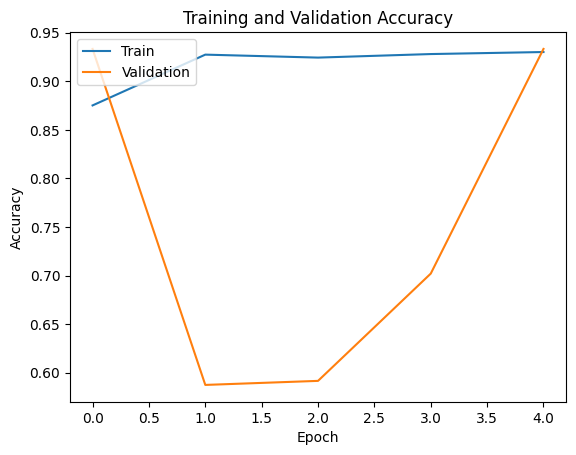

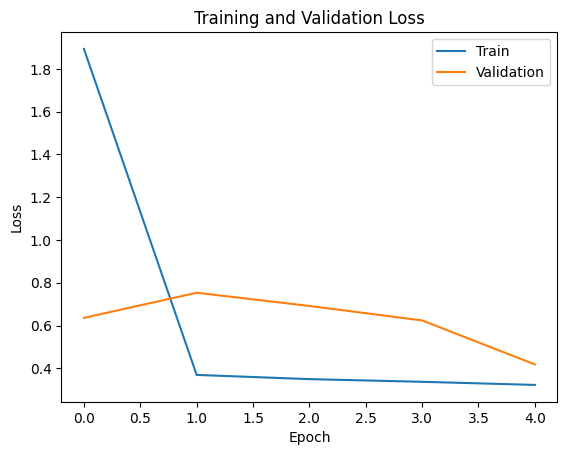

In [ ]:
# Plot training and validation accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Plot training and validation loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.show()

In [ ]:
test_datagen = ImageDataGenerator(rescale=1.0/255.0)

# Load the annotations test file into a DataFrame
df = pd.read_csv(annotations_test_file)
df['class'] = df['class'].astype(str)

# Load and preprocess the test data
test_generator = test_datagen.flow_from_dataframe(
    dataframe=df,
    directory=test_data_dir,
    x_col='filename',
    y_col='class',
    target_size=(224, 224),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
)

# Evaluate the model on the test data
loss, accuracy = model.evaluate(test_generator)

print(f'Test loss: {loss:.4f}')
print(f'Test accuracy: {accuracy:.4f}')


Found 4598 validated image filenames belonging to 3 classes.
9/9 [==============================] - 238s 25s/step - loss: 0.7572 - accuracy: 0.6667
Test loss: 0.7572
Test accuracy: 0.6667


Save Model

In [ ]:
from tensorflow.keras.models import load_model
model_path = '/content/drive/MyDrive/Flex Model/model_mobilenetv2_V1.h5'
model.save(model_path)